# Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import math
import glob
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense,Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import RepeatVector, MaxPooling2D, LSTM, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

# Create model

In [2]:
input_shape = Input(shape=(128, 32, 1))
# First layer
conv1 = Conv2D(32, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(input_shape)
batch1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch1)

# Second layer
conv2 = Conv2D(64, (5, 5), activation='relu', padding = 'SAME', strides = (1, 1))(pool1)
batch2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2,2),strides = (2, 2), padding = 'valid')(batch2)

# Third layer
conv3 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool2)
batch3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch3)

# Fourth layer          
conv4 = Conv2D(128, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool3)
batch4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch4)

# Fifth layer             
conv5 = Conv2D(256, (3, 3), activation='relu', padding = 'SAME', strides = (1, 1))(pool4)
batch5 = BatchNormalization()(conv5)
pool5 = MaxPooling2D(pool_size=(1,2),strides = (1, 2), padding = 'valid')(batch5)

# Reduce the dimension of output of fifth layer
cnn_input = tf.squeeze(pool5, [2])

# The output of convolutional layer is the input of bidirectional LSTM layer
forward_lstm = CuDNNLSTM(256, return_sequences=True)
backward_lstm = CuDNNLSTM(256, return_sequences=True, go_backwards=True)

bidirectional = Bidirectional(forward_lstm, backward_layer=backward_lstm)(cnn_input)

# output of model
output_layer = Dense(79, activation='softmax')(bidirectional)

my_model = Model(inputs = input_shape, outputs = output_layer)

# Preprocess image before prediction

In [3]:
def pre_process_image(path):
    
    img = path
        
    (wt, ht) = (128, 32)
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
                
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
                
    img = cv2.resize(img, newSize)
    img = img/255
                    
    target = np.ones([ht, wt]) * 255
                
    if newSize[1] < 32:
        img = np.concatenate((img, target[newSize[1]:32]), axis=0)    
                
    if newSize[0] < 128:
        img = np.concatenate((img, target[:,newSize[0]:128]), axis=1)
        
    img = cv2.transpose(img)

    img = img.reshape(128, 32, 1)

    
    return img

# Load the weight file

In [4]:
my_model.load_weights('C_LSTM_best.hdf5')

# Predict the output

In [5]:
def predict_output(img):
    # predict outputs
    prediction = my_model.predict(np.array([img]))

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True, beam_width=100, top_paths=1)[0][0])

    ## get the final text
    for x in out:
        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print(' ', end='')

# Word segmentation from hand weitten text image

In [6]:
# Line segmention
def line_segment(image):
    #conver image into gray image
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


    #binary threshold
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

    #dilation
    kernel = np.ones((15,100), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    #find contours
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return ctrs

# After line segmention, word segmention
def word_segment(line):
    #convert image into gray image
    gray = cv2.cvtColor(line,cv2.COLOR_BGR2GRAY)


    #binary
    ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

    #dilation
    kernel = np.ones((15,21), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)

    #find contours
    cntrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return cntrs

# Collect all word from the iamge for prediction 

In [9]:
image = cv2.imread('h01-004.png')

#find contours of line
ctrs_line = line_segment(image)

line_img = []

for i, ctr in enumerate(ctrs_line):
    x, y, w, h = cv2.boundingRect(ctr)
    roi = image[y:y+h, x:x+w]
    
    # this is used for making line in sorted 
    line_img.append((y, roi))
line_img = sorted(line_img, key=lambda entry:entry[0])

words = []

for line in line_img:
    img = line[1]
    
#     conours of each words
    cntrs_word = word_segment(img)
    word_img = []
    
    for i, cntr in enumerate(cntrs_word):
        x, y, w, h = cv2.boundingRect(cntr)
        roi = img[y:y+h, x:x+w]
        
        cv2.rectangle(img,(x,y),( x + w, y + h ),(0,255,0),1)
        
        # this is used for sorting words
        word_img.append((math.sqrt(x*x + y*y), roi))
    word_img = sorted(word_img, key=lambda entry:entry[0])
    
#   append all word into a list
    for w in word_img:
        words.append(w[1])

# cv2.imshow('segment no:',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
word = []

# convert all word image into gray
for i in range(len(words)):
    w = cv2.cvtColor(words[i], cv2.COLOR_BGR2GRAY)
    word.append(w)

# Plot the original Image

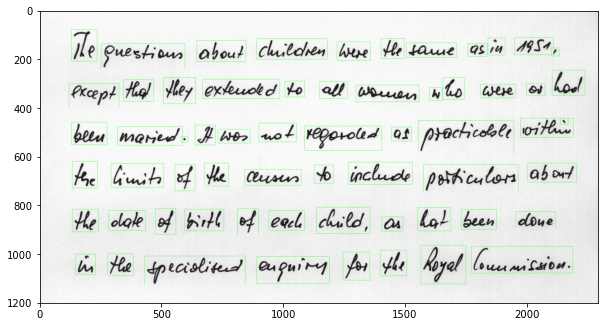

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)

# Prediction

In [11]:
for i in range(len(word)):
    test_img = pre_process_image(word[i])
    predict_output(test_img)